----
# VGG - Visual Geometry Group Model
-----

### Summary:
In this notebook, we will explore the application of the VGG-16 to analyse and interpret the features learned from the MNIST Sign Language Dataset.

VGG is a pre-defined CNN, trained on a very large image dataset (ImageNet). We will use features the model has learned from training and apply them to our datset. This process is called Transfer Learning. 

The purpose of using pre-trained models like VGG is due to their exposure to diverse images which enables them to capture a broader range of features.

### Data Overview:
- **Dataset:** MNIST Sign Language Dataset
- **Number of Samples:** Approximately 1400 images per character
- **Image Dimensions:** Each image consists of 784 pixel values (28x28 pixels flattened into a 1D array)

### Notebook Overview:

- **Data Loading:**
    - Load the MNIST Sign Language dataset.
    - Split data into training and validation datasets.
    - Scale X

- **Defining the VGG Model:**

    - Construct the VGG model architecture.
    - Define input layers, convolutional layers, pooling layers, and fully connected layers.

- **Training the VGG Model:**
    - Compile the model with loss function and optimiser.
    - Train the VGG model on the training data and validate its performance on the validation dataset.

- **Model Interpretability:**
    - Gain insights into what features the VGG model has learned by examining the kernels and feature maps.

- **Model Evaluation:**
    - Evaluate the accuracy and performance metrics of the trained VGG model on the validation dataset.
    - Analyse the model's performance using a confusion matrix and visualise misclassifications.

## Set Up
-----

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import joblib
import math
import seaborn as sns


In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)

## Utility Functions
-----

In [4]:
def img_resize(X_data, new_height, new_width, rgb= True):
    '''
        Overview:
        To resize input images to match network input layer.

        Arguments:
            - X_data: CNN model to inspect
            - new_height: input layer height
            - new_width: input layer width
            - rgb = True as default (RGB channels to 3 as default)

        Output:
            - Resized X_data
    '''
    # reshape to force X_data to have 4 dimenstions
    X_data = X_data.reshape(X_data.shape[0],X_data.shape[1],X_data.shape[2],-1)

    if rgb == True:
        # force X  to have three channels (RGB)
        X_rgb = np.repeat(X_data, 3, axis=-1) 
    else:
        pass

    # each image stored as single item in list
    resized_images = []
    for i in range(X_rgb.shape[0]):
        resized_image = tf.image.resize(X_rgb[i], size=[new_height,new_width])
        resized_images.append(resized_image)   
    
    # combines list of tensor items to single tensor item new dimenstion = num of images in list 
    X_resized = tf.stack(resized_images)
    
    return X_resized

In [5]:
def get_letter_img(X_data, letter):
  '''
    Overview:
    To get an image for a given letter, requires X/y to be defined.

    Arguments:
      - X_data: input data
      - letter: not including J or Z
    Output:
      - iamge of given letter 
  '''
  letter_idx = alphabet.index(letter.lower())
  X_resized = img_resize(X_data[y==letter_idx], 64, 64)

  letter_image = tf.reshape(X_resized[0], [1, 64, 64, 3])
  return letter_image

In [6]:
def get_conv_layer_ouput(model, layer_name, input_img):
  '''
    Overview:
    Visualizes the output of the given layer.

    Arguments:
        - model: A trained Keras model.
        - input_image: The input image to pass through the model.
        - layer_name: The name of the layer to be visualized.

    Output:
        - feature maps for given layer
  '''
  # force input_img shape to match model input shape
  input_img =  tf.reshape(input_img, [1, 64, 64, 3])

  conv_model = keras.Model(inputs= model.input, outputs = model.get_layer(layer_name).output)
  output_conv = conv_model.predict(input_img)

  num_kernels = output_conv.shape[-1]
  #output_conv[0,:,:,0] ->  results of first feature map when passed over the first filter

  rows = math.ceil(num_kernels/4)

  fig, axes = plt.subplots(rows,4,figsize=(20,4*rows))
  ax = axes.flatten()

  for i in range(num_kernels):
    ax[i].imshow(output_conv[0,:,:,i], cmap='viridis')
    ax[i].set_title(f'Kernel {i+1} Output', fontsize = '20')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
  plt.show()


In [7]:
def kernel_with_output(model,input_image, layer_name, kernel=1):
  '''
    Overview:
    Visualizes the output of the specified layer and kernel.

    Arguments:
        - model: A trained Keras model.
        - input_image: The input image to pass through the model.
        - layer_name: The name of the layer to be visualized.
        - kernel: kernel to view.

    Output:
        - Outputs three figures:
            - Input image
            - Kernel (weights)
            - Output of kernel after convolving the input image
  '''
  kernel_pos = kernel - 1

  weights, bias = model.get_layer(layer_name).get_weights()

  fig,axes = plt.subplots(1,3,figsize=(20, 10))

  input_image = tf.squeeze(input_image, axis=0).numpy()
  input_image = input_image.astype(int)

  axes[0].imshow(input_image,cmap='gray')
  axes[0].set_title(f'Input Image', fontsize = '30')
  axes[0].set_xticks([])
  axes[0].set_yticks([])

  # gray_r => now dark regions show "patterns" for each kernel
  axes[1].imshow(weights[:,:,0,kernel_pos], cmap='gray_r')
  axes[1].set_title(f'Kernel {kernel}', fontsize = '30')
  axes[1].set_xticks([])
  axes[1].set_yticks([])

  test_input =  tf.reshape(input_image, [1, 64, 64, 3])

  # Redefine the model so the output is the after the provided layer
  output_conv = model.get_layer(layer_name).output
  conv_model = keras.Model(inputs= model.input, outputs = output_conv)
  pred = conv_model.predict(test_input)

  axes[2].imshow(pred[0,:,:,kernel_pos], cmap='viridis')
  axes[2].set_title(f'Kernel {kernel} Output', fontsize = '30')
  axes[2].set_xticks([])
  axes[2].set_yticks([])

  plt.show()

In [8]:
def inspect_weights(model, layer_name):
  '''
    Overview:
    To get weights from a given layer.

    Arguments:
        - model: CNN model to inspect
        - layer_name: name of layer to access weights

    Output:
        - kernels (weights) as a 3x3 image
  '''
  layer = model.get_layer(layer_name)
  weights, baises = layer.get_weights()

  num_kernels = weights.shape[-1]
  rows = math.ceil(num_kernels/4)

  fig, axes = plt.subplots(rows,4,figsize=(20,4*rows))

  for i, ax in enumerate(axes.flatten()):
      if i < num_kernels:
          ax.imshow(weights[:, :, 0, i], cmap='gray_r')
          ax.set_title(f'Kernel {i+1}', fontsize=20)
          ax.set_xticks([])
          ax.set_yticks([])
      else:
          fig.delaxes(ax)  # Delete unused subplots

  plt.show()

## Data Loading
---

In [9]:
X = joblib.load( '../../data/my_data/X.pkl')
y = joblib.load( '../../data/my_data/y.pkl')

In [10]:
X = X.reshape(-1,28,28)
X.shape

(34627, 28, 28)

### Train/Validation Split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

### Scaling X

In [12]:
# Modify the X values to be 0-1 instead of 0-255
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_val /= 255
# Sanity Check
print(f'X_train range: {X_train.min()}-{X_train.max()}')

X_train range: 0.0-1.0


In [13]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
unique_values, value_counts = np.unique(y, return_counts=True)

## Defining VGG-16 Architecture
----

VGG-16 is made up of 16 layers, 13 layers are convolutional layers and the last 3 layers are fully connected layers. VGG uses blocks in order to improve performance. 

Each block contains multiple convolutional layers followed by max pooling. This allows the netowrk to mantain its depth without reducing the spatial dimensions too much. This improves feature extraction across different levels and so increases the performance.

Below is a diagram of what VGG-16 architecture looks like: [1]


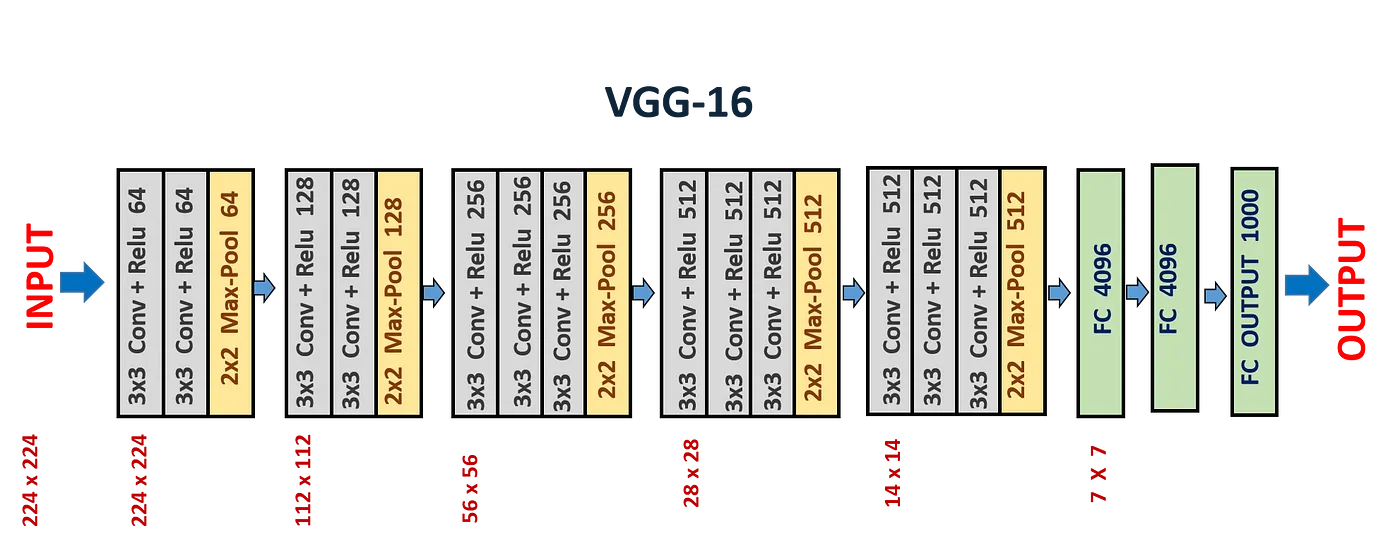

In [38]:
from tensorflow.keras.applications.vgg16 import VGG16

In [39]:
num_output_classes = len(np.unique(y))

In [40]:
my_vgg = keras.applications.VGG16(include_top=False, # Set to false to only load the conv layers, will be swapping out the top layers for ownß
                                     weights='imagenet', 
                                     input_tensor=None,
                                     input_shape=(64,64,3), # changing input shape to (32,32,3) 32 is minimium size
                                     pooling=max, # for my output will use pooling
                                     classes= num_output_classes, # setting to len of my y (24)
                                     classifier_activation='softmax' # keep as softmax for output layer
                                 )


In [41]:
# Freezing all weights - I am using weights from imagenet 
my_vgg.trainable = False 

In [42]:
my_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

### Adding my own top layers

In [43]:
my_model = Sequential([my_vgg,
                       layers.Flatten(),
                       layers.Dense(128, activation='relu'),
                       layers.Dense(64, activation="relu"),
                       layers.Dense(num_output_classes, activation="softmax")
                       ])



In [44]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
Total params: 14,986,776
Trainable params: 272,088
Non-trainable params: 14,714,688
_________________________________________________________________


In [45]:
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

## Train model using the original MNIST data
---

In [14]:
# Resize X_train and X_val to fit input dimesntions for VGG
X_train_resized = img_resize(X_train, 64, 64)
X_val_resized = img_resize(X_val, 64, 64)

In [47]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [48]:
history = my_model.fit(X_train_resized, y_train,
                        batch_size = 128,
                        epochs = 20,
                        verbose = 1,
                        validation_split = 0.2,
                        callbacks=[early_stop])

Epoch 1/20
174/174 [==============================] - 372s 2s/step - loss: 1.0218 - accuracy: 0.7463 - val_loss: 0.2706 - val_accuracy: 0.9478
Epoch 2/20
174/174 [==============================] - 315s 2s/step - loss: 0.1458 - accuracy: 0.9823 - val_loss: 0.0833 - val_accuracy: 0.9930
Epoch 3/20
174/174 [==============================] - 307s 2s/step - loss: 0.0513 - accuracy: 0.9969 - val_loss: 0.0353 - val_accuracy: 0.9982
Epoch 4/20
174/174 [==============================] - 444s 3s/step - loss: 0.0254 - accuracy: 0.9989 - val_loss: 0.0188 - val_accuracy: 0.9991
Epoch 5/20
174/174 [==============================] - 554s 3s/step - loss: 0.0135 - accuracy: 0.9995 - val_loss: 0.0120 - val_accuracy: 0.9995
Epoch 6/20
174/174 [==============================] - 356s 2s/step - loss: 0.0096 - accuracy: 0.9997 - val_loss: 0.0092 - val_accuracy: 0.9993
Epoch 7/20
174/174 [==============================] - 393s 2s/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9995

### Saving model

In [49]:
my_model.save('../../model/my_models/VGG_model.h5')

### Assessing training and validation scores

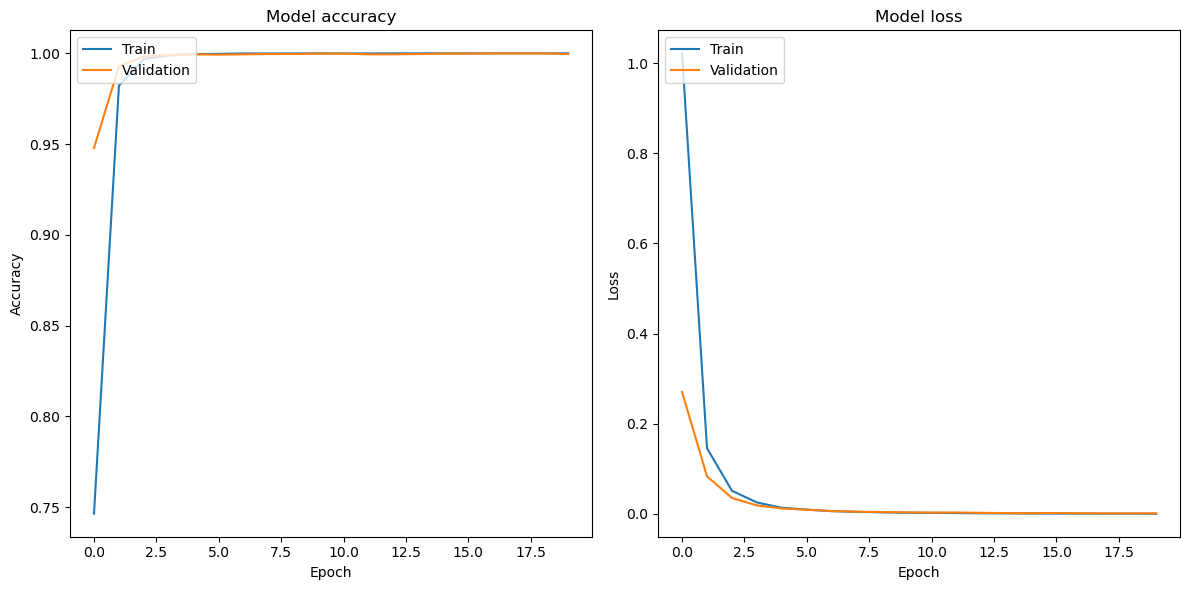

In [50]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [51]:
train_loss, train_acc = my_model.evaluate(X_train_resized, y_train)
print('Train accuracy:', train_acc)

866/866 [==============================] - 312s 360ms/step - loss: 5.6287e-04 - accuracy: 0.9999
Train accuracy: 0.999927818775177


In [52]:
print(f'VGG model Training Score: {round(train_acc*100,4)}')

VGG model Training Score: 99.9928


In [53]:
# Evaluate the model's performance
val_loss, val_acc= my_model.evaluate(X_val_resized, y_val, verbose=1)
print('Val accuracy:', val_acc) 

217/217 [==============================] - 83s 384ms/step - loss: 0.0020 - accuracy: 0.9996
Val accuracy: 0.9995668530464172


In [54]:
print(f'VGG model Validation Score: {round(val_acc*100,4)}')

VGG model Validation Score: 99.9567


## Model Interpretability
----

In [13]:
VGG_model = load_model('../../model/my_models/VGG_model.h5')

In [25]:
vgg_layers = VGG_model.layers[0] # to access the vgg layers

In [26]:
# getting all convoluted layers out of vgg
conv_layer = []
for layer in vgg_layers.layers:
    if isinstance(layer,Conv2D):
        conv_layer.append(layer.name)


In [27]:
# to get conv layer names
conv_layer

['block1_conv1',
 'block1_conv2',
 'block2_conv1',
 'block2_conv2',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3']

### Inspecting weights

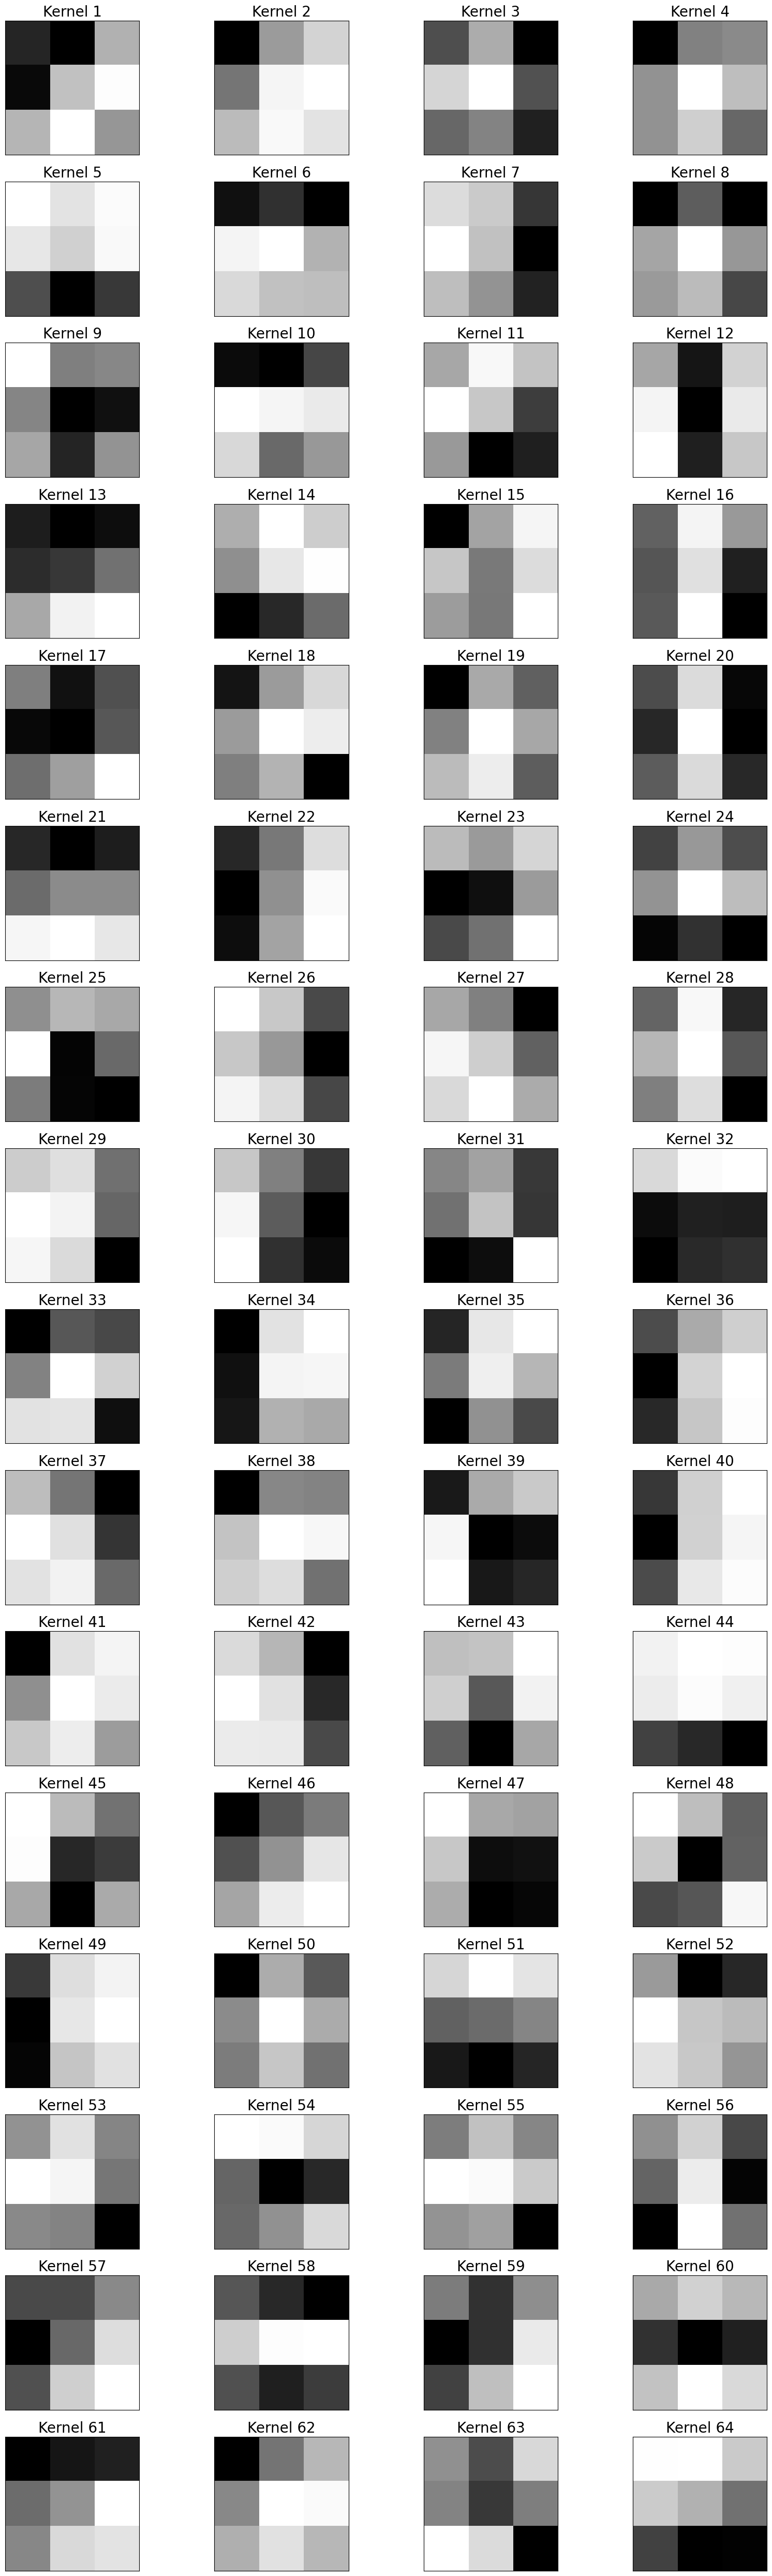

In [28]:
inspect_weights(vgg_layers, 'block1_conv2')

**Plot Description:**

Similar to the plot in the CNN notebook, this plot shows us the weights for each kernel in a given layer of the VGG model. Darker regoins signify larger weights suggesting these regions represent patterns which the filter is searching for in the input image. 

### Inspecting feature maps

1/1 [==============================] - 0s 23ms/step


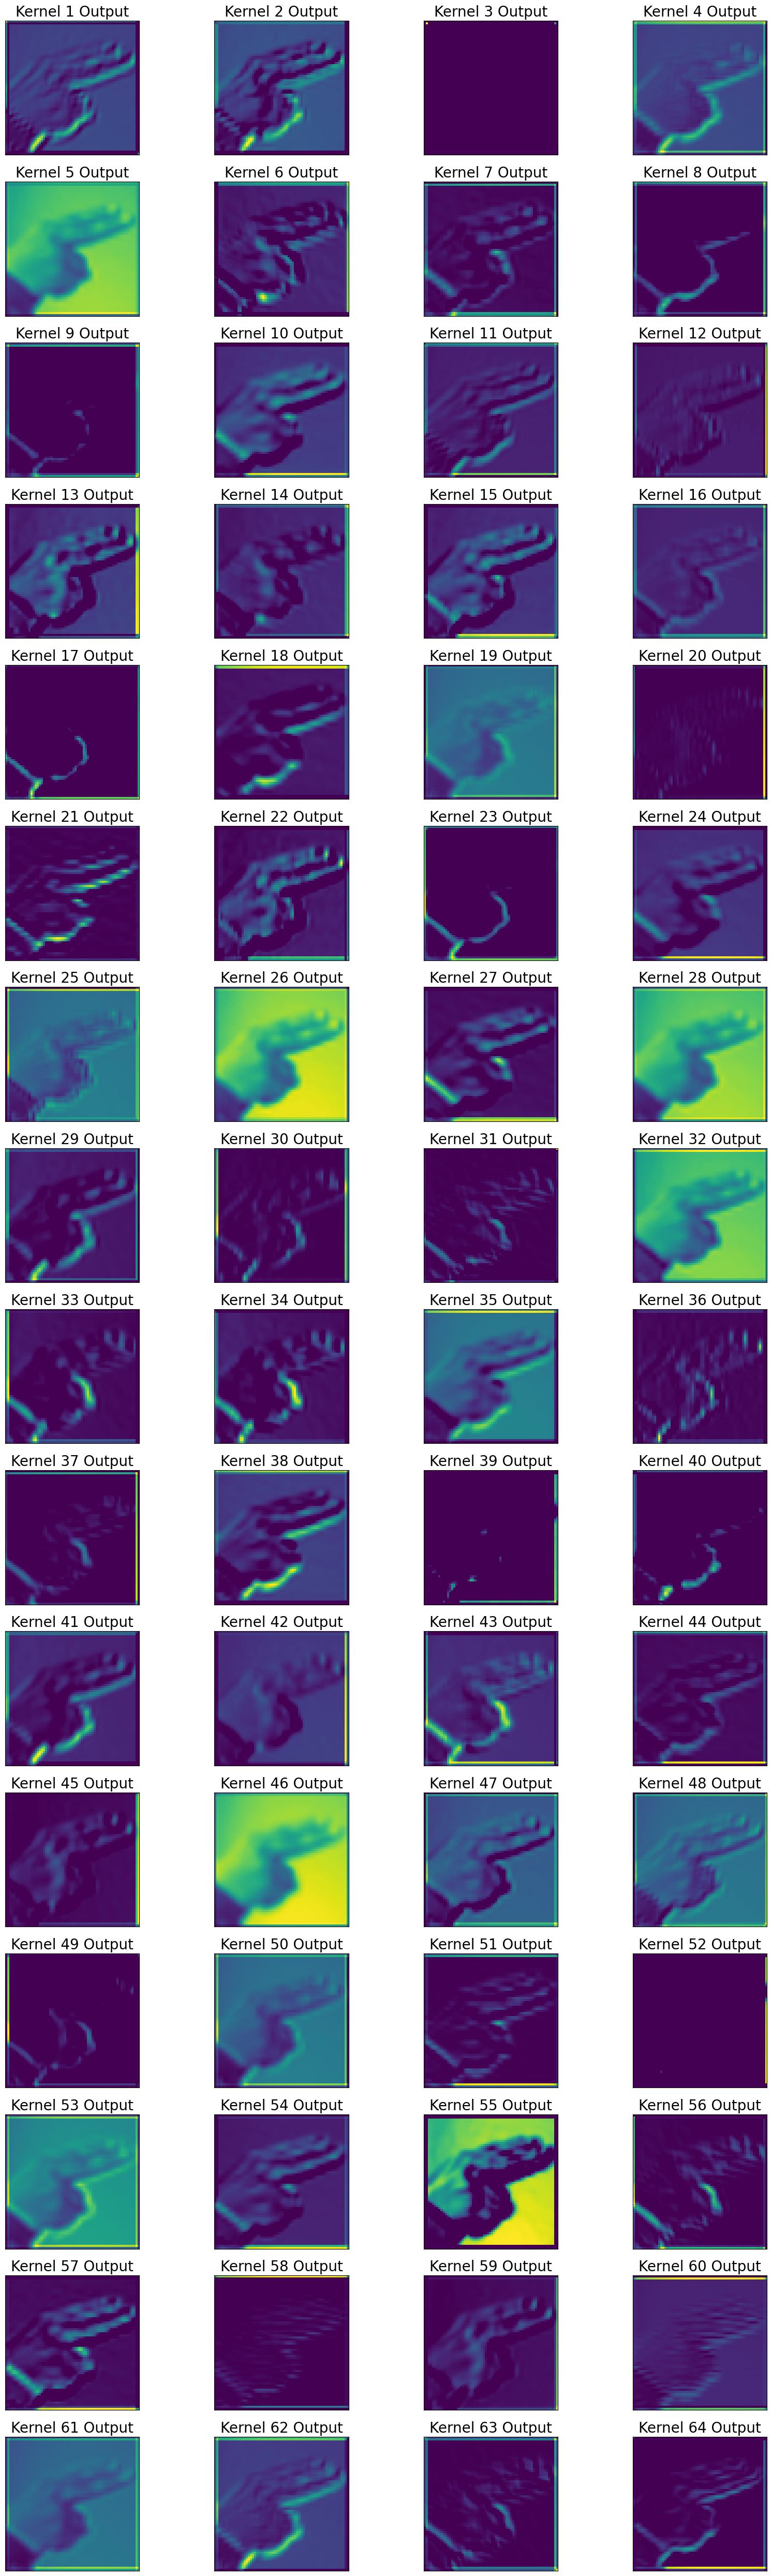

In [31]:
get_conv_layer_ouput(vgg_layers,'block1_conv2',get_letter_img(X,'h'))

**Plot Description:**

Similar to the plot in the CNN notebook, this plot shows us the feature maps after each kernel convolves over the input image (or previous conv layer ouptut dependion which layer is fed in to the function).

ighter regions indicate areas where the kernel has detected relevant features according to its learned weights. 

Darker regoins indicatge areas the features between filter and the image are less similar.



### Comparison of input image and feature map for a specific layer and kernel

1/1 [==============================] - 0s 24ms/step


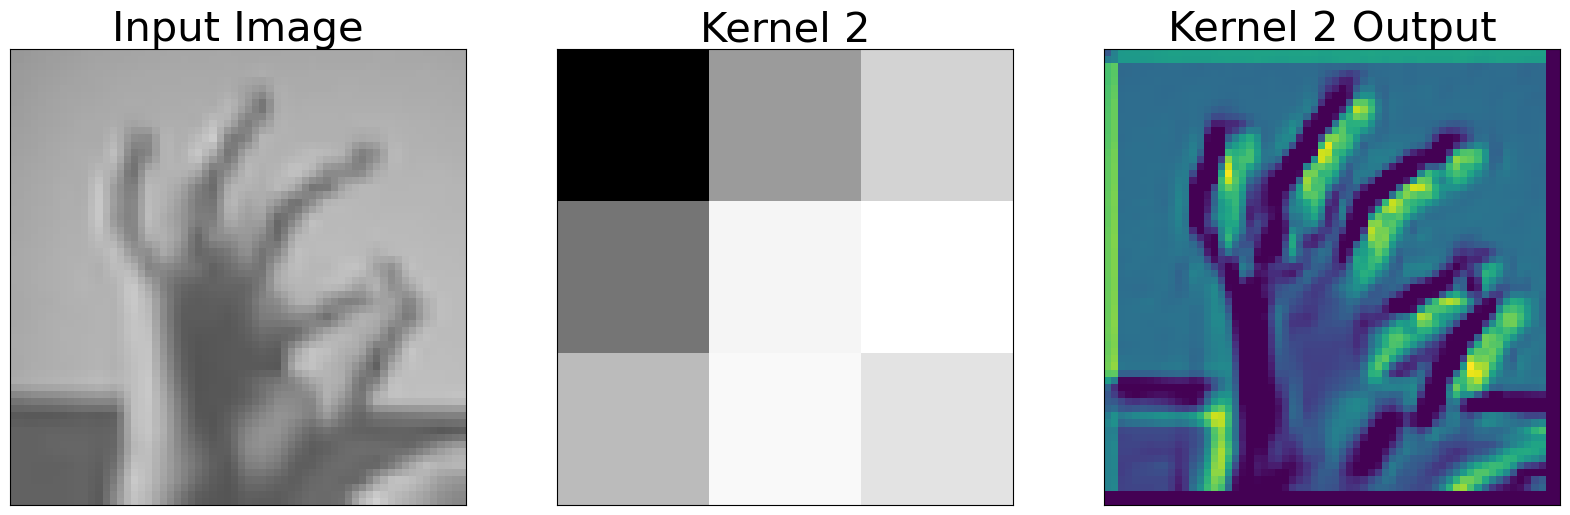

In [35]:
kernel_with_output(model = vgg_layers,input_image = get_letter_img(X,'f'), layer_name = 'block1_conv2', kernel=2)

**Plot Description:**

In the example above, it is likely Kernel 2 is used to detect edges of fingers in the input image. 

## Model Evaluation
-----

In [15]:
VGG_model = load_model('../../model/my_models/VGG_model.h5')

### Confusion Matrix

2024-07-07 15:33:16.829849: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


217/217 [==============================] - 145s 670ms/step


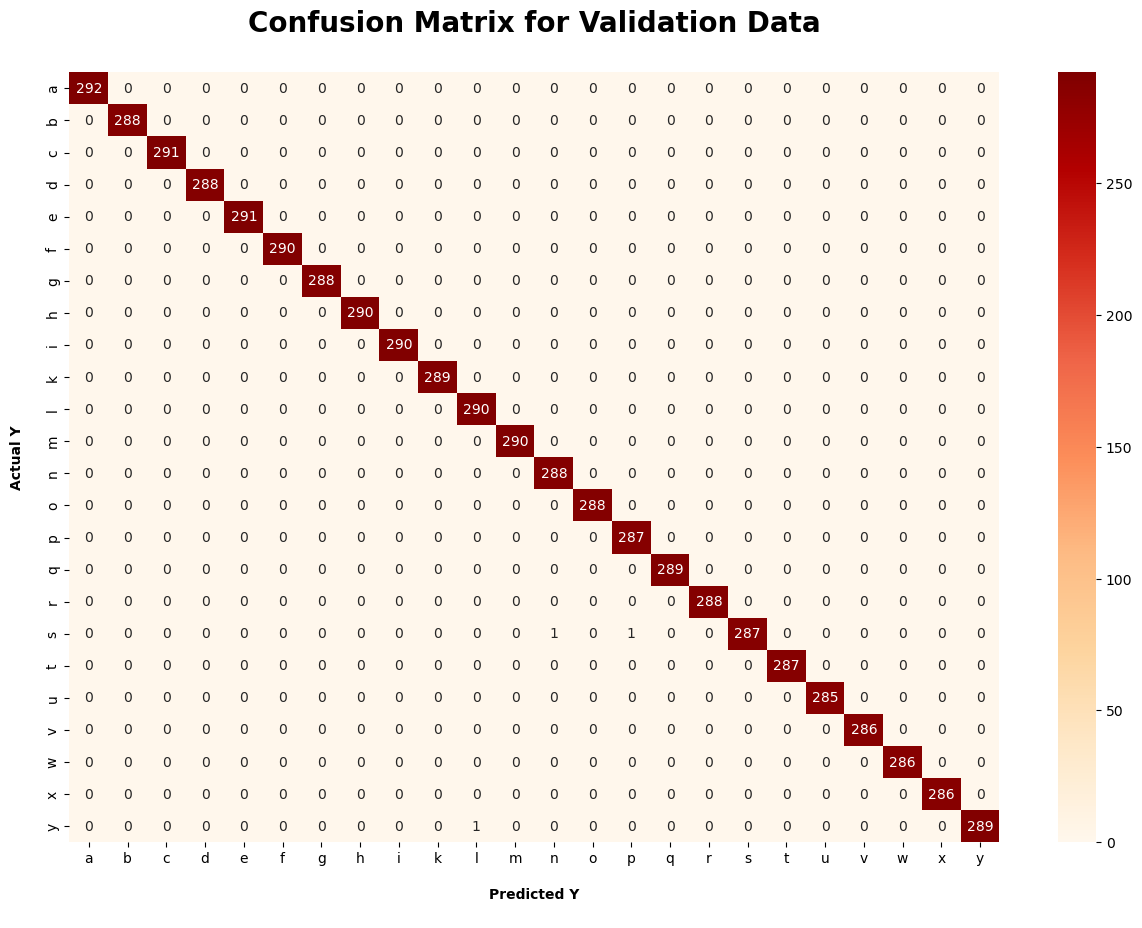

In [16]:
pred_y = np.argmax(VGG_model.predict(X_val_resized), axis=1)

conf_matrix = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd') # -> fmt = d casting values to int
plt.title('Confusion Matrix for Validation Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

### Visualising Misclassifications

In [17]:
incorrect_photos = (y_val != pred_y)

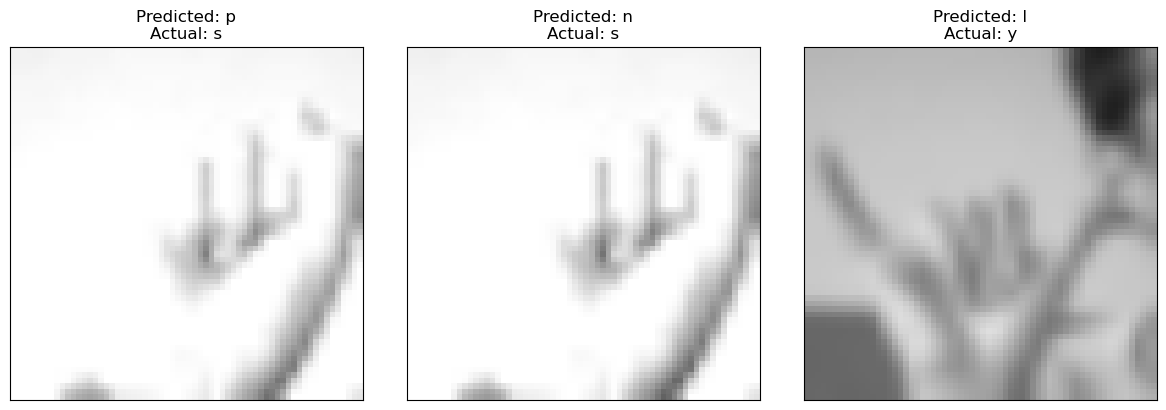

In [20]:
num_photos = incorrect_photos.sum()
rows = math.ceil(num_photos/5)

if num_photos == 0:
    print('There are no misclassifications to show!')
else:
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))

    for i, ax in enumerate(axes.flatten()):
        if i < num_photos:
            ax.imshow(X_val_resized[incorrect_photos][i], cmap='gray')

            # Get predicted label
            p = pred_y[incorrect_photos][i]
            prediction = alphabet[p]

            # Get actual label
            a = y_val[incorrect_photos][i]
            actual = alphabet[a.astype(np.int32)]

            # Set the title of the subplot
            ax.set_title(f"Predicted: {prediction}\nActual: {actual}")

            # Hide the x and y ticks
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            fig.delaxes(ax)  # Delete unused subplots

    plt.tight_layout()
    plt.show()

**Plot Description:**

Many of the misclassifications are for closed signs such as S These signs are very similar to each other, the only difference is the placement of the thumb. These images are quite bright making it hard for the model to distinguish thumb placement betwen these signs. 

In addition to this, we also see cases where the background is not clear such as the misclassification of Y. This can also confuse the model causing it to misclassify.



### Testing an Unseen Input Image

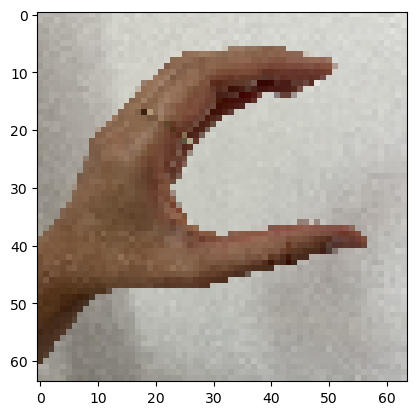

In [48]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# loading a test image for ASL sign 'C'
image_path = '../../data/my_imgs/C.JPG'
input_image = load_img(image_path, target_size=(64, 64))
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)
plt.imshow(input_image) # checking image has correct orientation
plt.show()

In [49]:
image_array = img_to_array(input_image)
test_img = image_array.reshape(1, image_array.shape[0], image_array.shape[1], image_array.shape[2])

In [50]:
soft_pred = VGG_model.predict(test_img)
pred_y = np.argmax(soft_pred, axis=1)

1/1 [==============================] - 0s 300ms/step


In [51]:
print(f'Prediction using VGG: \n{alphabet[pred_y[0]].upper()}')

Prediction using VGG: 
C


## Conclusion
---------

|                  | VGG Model     |
|------------------|---------------|
| Train Score      | 99.99         |
| Validation Score | 99.96         |

The accuracy scores of VGG suggest the model has effectively learnt to distinguish between the letters. The small difference between the train and validation score also suggests the model is not overfitting and has learned to generalise well to unseen data. 

Moving forward, the model's ability to handle augmented data will be tested in order to validate the model's robustness.

## References
-----
[1] : https://pub.towardsai.net/the-architecture-and-implementation-of-vgg-16-b050e5a5920b